In [1]:
import numpy as np
import pandas as pd
import ee
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras import optimizers

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VM-JfmKvI48IX3n6qFZS2dV4EELx-4r6qPJyVNvrNa-oR16ZEjlXeQ

Successfully saved authorization token.


In [3]:
# Define the latitude and longitude of the point
lat = 24.3357
lon = -0.7778

# Create a point geometry
point = ee.Geometry.Point(lon, lat)
#CNN-LSTM
#Define the number of years of data to use for training
train_years = 12

#Define the number of days of data to use for each time step
time_steps = 30

#Define the number of time steps to uses for each training sequence
sequence_length = 30

# Define the number of filters and kernel size for the CNN layer
num_filters = 64
kernel_size = 3

# Define the number of LSTM units for the LSTM layer
num_lstm_units = 128

# Define the number of epochs and batch size for training
num_epochs = 100
batch_size = 32

# Define the time range for the data
start_date = ee.Date('2004-01-01')
end_date = ee.Date('2020-12-31')

# Retrieve temperature data from Earth Engine
temp_collection = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_RAW') \
    .select('temperature_2m')\
    .filterDate(start_date, end_date)
    
#Reduce the image collection to a single image at the given loacation and time
temp_image = temp_collection.filterBounds(point)

# Extract thetemperature value at the give region
temp_data = temp_image.getRegion(point, scale =0.02).getInfo()
   
#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','temperature']
temp_df = pd.DataFrame(temp_data[1:], columns=columns)
temp_df.set_index('time', inplace = True)

#Convert temperature column to float and replace missing values with NaN
temp_df['temperature'] =  pd.to_numeric(temp_df['temperature'], errors='coerce')-273.15

# Convert the index to a datetime object
temp_df.index = pd.to_datetime(temp_df.index, format='%Y%m%d')

# Resample the data to daily frequency
temp_df_daily = temp_df.resample('1D').mean()


<Axes: xlabel='time'>

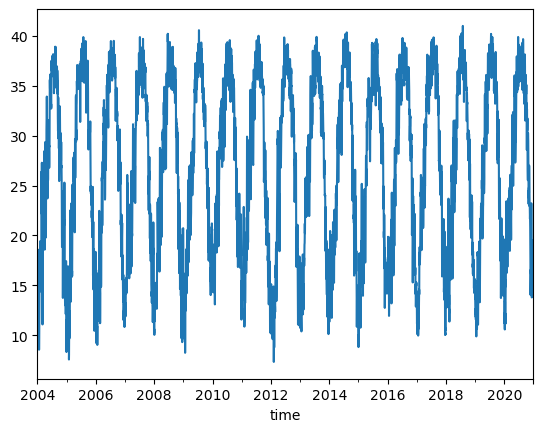

In [4]:
temp_df_daily['temperature'].plot()

In [5]:
temp_daily=temp_df_daily['temperature']

In [6]:
temp_daily

time
2004-01-01    12.935125
2004-01-02    13.686184
2004-01-03    15.123820
2004-01-04    13.970753
2004-01-05    12.482061
                ...    
2020-12-26    16.356433
2020-12-27    15.471014
2020-12-28    14.577444
2020-12-29    18.654371
2020-12-30    18.869991
Freq: D, Name: temperature, Length: 6209, dtype: float64

In [8]:
#Check for null values
temp_daily.isnull().sum()

0

In [9]:
# Define the input and output variables for the model
X = []
y = []

# Iterate over each sequence in the dataset
for i in range(len(temp_daily) - sequence_length - 1):
    # Extract a sequence of temperature values
    seq_temp = temp_daily.values[i:i+sequence_length]
    # Define the target precipitation value
    target_temp = temp_daily.values[i+sequence_length]
    
    # Append the sequence and target values to the input and output lists
    X.append(seq_temp)
    y.append(target_temp)
    
# Convert the input and output lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [10]:
#Split the data into train and valid dataset
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.4, random_state=0)

print('Train set shape', X_train.shape)
print('Test set shape', X_valid.shape)

Train set shape (3706, 30)
Test set shape (2472, 30)


In [11]:
subsequences=2
timesteps = X_train.shape[1]//subsequences
X_train_sub=X_train.reshape((X_train.shape[0], subsequences, timesteps,1))
X_valid_sub=X_valid.reshape((X_valid.shape[0], subsequences, timesteps,1))

print('Train set shape', X_train_sub.shape)
print('Test set shape', X_valid_sub.shape)

Train set shape (3706, 2, 15, 1)
Test set shape (2472, 2, 15, 1)


In [115]:
epochs = 35
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [15]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_sub.shape[2], X_train_sub.shape[3])))
#model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
#model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
#model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
#model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

print(model_cnn_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, None, 15, 64)     128       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 960)        0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 64)                262400    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 262,593
Trainable params: 262,593
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_sub, y_train, validation_data=(X_valid_sub, y_valid), epochs=30, verbose=1)

Epoch 1/30
116/116 [==============================] - 7s 35ms/step - loss: 32.7329 - val_loss: 8.0923
Epoch 2/30
116/116 [==============================] - 3s 26ms/step - loss: 6.8432 - val_loss: 6.6079
Epoch 3/30
116/116 [==============================] - 4s 31ms/step - loss: 4.6656 - val_loss: 5.0954
Epoch 4/30
116/116 [==============================] - 3s 30ms/step - loss: 4.0980 - val_loss: 3.5658
Epoch 5/30
116/116 [==============================] - 4s 31ms/step - loss: 3.4664 - val_loss: 3.1877
Epoch 6/30
116/116 [==============================] - 3s 29ms/step - loss: 3.1894 - val_loss: 3.4452
Epoch 7/30
116/116 [==============================] - 3s 30ms/step - loss: 3.2093 - val_loss: 3.3156
Epoch 8/30
116/116 [==============================] - 3s 26ms/step - loss: 3.0166 - val_loss: 2.5573
Epoch 9/30
116/116 [==============================] - 4s 35ms/step - loss: 2.6022 - val_loss: 2.5506
Epoch 10/30
116/116 [==============================] - 3s 28ms/step - loss: 2.5834 - val_l

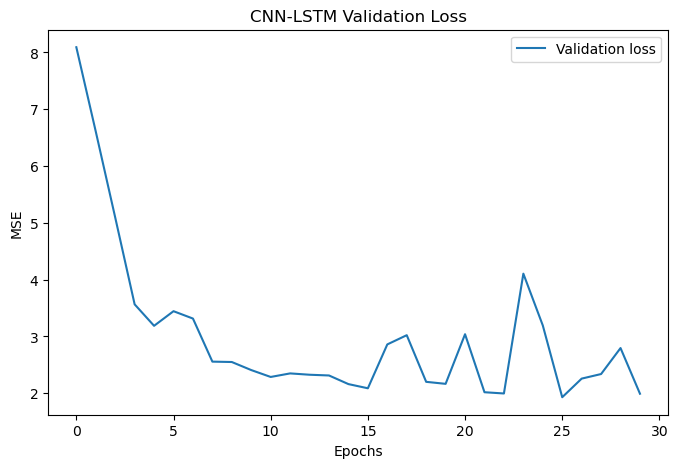

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax.legend(loc='best')
ax.set_title('CNN-LSTM Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()



In [18]:
# Compute the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_sub)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_lstm_valid_pred)))

78/78 [==============================] - 0s 3ms/step
Train rmse: 1.356587660395142
Validation rmse: 1.4114768359993315


In [66]:
cnn_lstm_valid_predd = cnn_lstm_valid_pred.reshape(2472)

In [59]:
cnn_lstm_train_predd = cnn_lstm_train_pred.reshape(3706)

In [67]:
import matplotlib.pyplot as plt

# assuming you have numpy arrays for train and test data and a pandas Series for temp_daily
cnn_lstm_train_predd = <numpy array of shape (3706,)>
cnn_lstm_train_predd= <numpy array of shape (2472,)>
temp_daily = <pandas Series of shape (6209,)>

# plot the entire temp_daily data
plt.plot(temp_daily)

# plot the train data with a different color
plt.plot(temp_daily[:len(train_data)], color='blue')

# plot the test data with a different color
plt.plot(temp_daily[-len(test_data):], color='green')

# add legend and show the plot
plt.legend(['temp_daily', 'train_data', 'test_data'])
plt.show()


SyntaxError: invalid syntax (188767949.py, line 4)

In [62]:
#shift train predictions for plotting
look_back = 100
trainPredictplot = np.empty_like(temp_daily)
trainPredictplot[:]=np.nan
trainPredictplot[look_back:len(cnn_lstm_train_predd)+look_back] = cnn_lstm_train_predd
#Shitft the test prediction for plotting
testPredictplot = np.empty_like(temp_daily)
testPredictplot[:] = np.nan
testPredictplot[len(cnn_lstm_train_predd)+(look_back*2)+1:len(temp_daily)] = cnn_lstm_valid_predd
#plot baseline and predictions
plt.figure(figsize=(8,5))
plt.plot(temp_daily, color='black', label='actual data')
plt.plot(trainPredictplot, color='orange',label='train prediction')
plt.plot(testPredictplot, color='red',label= 'test prediction')
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (2470,) into shape (2302,)

In [64]:
temp_daily.shape

(6209,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


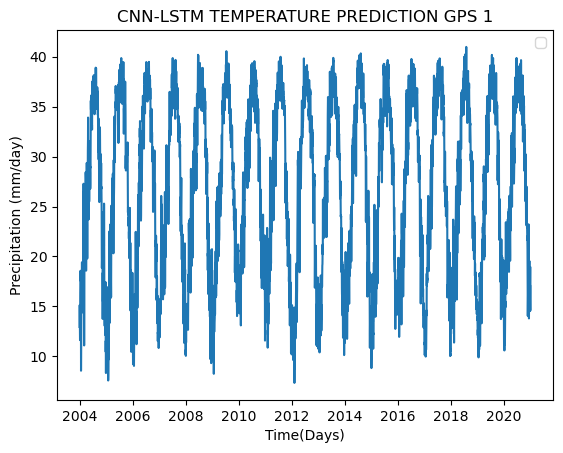

In [22]:
#Plot the comparison between actual temperature and predicted temperature
import matplotlib.pyplot as plt
plt.plot(temp_daily)      
#plt.plot(cnn_lstm_train_pred,color='black', label='actual temperature')
#plt.plot(cnn_lstm_valid_pred, color='red', label='predicted temperature')
plt.title('CNN-LSTM TEMPERATURE PREDICTION GPS 1')
plt.xlabel('Time(Days)')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.show()

In [134]:
# Initialize the plot arrays
cnn_lstm_train_plot = np.empty((len(temp_daily), 1))
cnn_lstm_train_plot[:, :] = np.nan
cnn_lstm_train_plot[look_back:len(cnn_lstm_train_pred)+look_back, :] = cnn_lstm_train_pred
valid_start = look_back + len(cnn_lstm_train_pred) + (look_back * 2)
valid_end = valid_start + len(cnn_lstm_valid_pred)

# Adjust valid_start to match the size of cnn_lstm_valid_pred
valid_start_adjusted = valid_start - (len(temp_daily) - len(cnn_lstm_valid_pred))

cnn_lstm_valid_plot = np.empty((len(temp_daily), 1))
cnn_lstm_valid_plot[:, :] = np.nan
cnn_lstm_valid_plot[valid_start_adjusted:valid_end, :] = cnn_lstm_valid_pred

# Plot the baseline and predictions
plt.plot(temp_daily ,label='actual temperature')
plt.plot(cnn_lstm_train_plot,label='training set prediction')
plt.plot(cnn_lstm_valid_plot,label='validation set prediction')
plt.title('CNN-LSTM model predictions')
plt.xlabel('Time (days)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()




ValueError: could not broadcast input array from shape (2472,1) into shape (6150,1)

In [69]:
cnn_lstm_train_pred.shape

(3706, 1)

In [95]:
y_valid

array([14.5774437 , 38.36932208, 33.74430745, ..., 21.69704908,
       12.08685265, 18.49703178])

In [96]:
X_train_subx = np.expand_dims(X_train_sub, axis=-1)
X_valid_subx = np.expand_dims(X_valid_sub, axis=-1)

In [85]:
#CNN model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1],1)))
#model_cnn.add(Conv1D(filters=64, kernel_size=1, activation='relu',))
#model_cnn.add(Conv1D(filters=64, kernel_size=1, activation='relu',))
#model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.compile(loss='mse', optimizer='adam')

print(model_cnn.summary())


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 30, 64)            128       
                                                                 
 flatten_14 (Flatten)        (None, 1920)              0         
                                                                 
 dense_20 (Dense)            (None, 128)               245888    
                                                                 
Total params: 246,016
Trainable params: 246,016
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
cnn_history = model_cnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, verbose=1)

Epoch 1/35
116/116 [==============================] - 1s 7ms/step - loss: 310.6545 - val_loss: 289.3861
Epoch 2/35
116/116 [==============================] - 1s 6ms/step - loss: 289.5000 - val_loss: 288.1389
Epoch 3/35
116/116 [==============================] - 1s 7ms/step - loss: 288.2806 - val_loss: 287.0793
Epoch 4/35
116/116 [==============================] - 1s 7ms/step - loss: 287.5261 - val_loss: 286.7042
Epoch 5/35
116/116 [==============================] - 1s 6ms/step - loss: 287.1484 - val_loss: 286.2334
Epoch 6/35
116/116 [==============================] - 1s 6ms/step - loss: 286.8807 - val_loss: 285.9352
Epoch 7/35
116/116 [==============================] - 1s 6ms/step - loss: 286.6850 - val_loss: 285.9088
Epoch 8/35
116/116 [==============================] - 1s 6ms/step - loss: 286.5046 - val_loss: 285.5844
Epoch 9/35
116/116 [==============================] - 1s 7ms/step - loss: 286.4304 - val_loss: 285.5076
Epoch 10/35
116/116 [==============================] - 1s 6ms/st

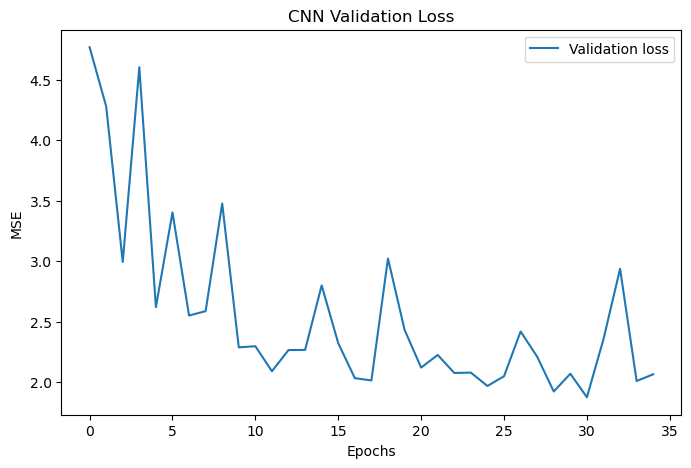

In [87]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax.legend(loc='best')
ax.set_title('CNN Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()


In [88]:
# Compute the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_sub)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_lstm_valid_pred)))

78/78 [==============================] - 0s 4ms/step
Train rmse: 1.3723345870016221
Validation rmse: 1.4362935155940424


In [ ]:
Plot the comparison between actual temperature and predicted temperature
import matplotlib.pyplot as plt
      
#plt.plot(y_valid ,color='black', label='actual precipitation')
plt.plot(cnn_lstm_valid_pred, color='red', label='predicted precipitation')
plt.title('CNN-TEMPERATURE PREDICTION GPS 1')
plt.xlabel('Time(Days)')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.show()

In [ ]:
#LSTM

In [80]:
model1=Sequential()
model1.add(LSTM(128, input_shape =(X_train.shape[1], 1), activation='relu', return_sequences=True))
model1.add(LSTM(128, activation='relu', return_sequences=True))
model1.add(LSTM(64, activation='relu'))
model1.add(Dense(1))
model1.compile(loss='mse', optimizer='adam')

print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 128)           66560     
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           131584    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 247,617
Trainable params: 247,617
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
history = model1.fit(X_train ,y_train, validation_data =(X_valid, y_valid), epochs =35, verbose=1)

Epoch 1/35
116/116 [==============================] - 12s 74ms/step - loss: 132.3159 - val_loss: 4.8748
Epoch 2/35
116/116 [==============================] - 8s 68ms/step - loss: 3.8606 - val_loss: 4.1225
Epoch 3/35
116/116 [==============================] - 9s 74ms/step - loss: 2.7026 - val_loss: 2.1875
Epoch 4/35
116/116 [==============================] - 9s 74ms/step - loss: 2.1032 - val_loss: 1.9927
Epoch 5/35
116/116 [==============================] - 9s 74ms/step - loss: 1.9586 - val_loss: 2.4783
Epoch 6/35
116/116 [==============================] - 11s 95ms/step - loss: 1.9777 - val_loss: 2.0958
Epoch 7/35
116/116 [==============================] - 8s 70ms/step - loss: 2.0271 - val_loss: 2.2312
Epoch 8/35
116/116 [==============================] - 11s 93ms/step - loss: 1.9032 - val_loss: 1.9724
Epoch 9/35
116/116 [==============================] - 11s 95ms/step - loss: 1.8661 - val_loss: 1.9666
Epoch 10/35
116/116 [==============================] - 8s 68ms/step - loss: 1.9423 - 

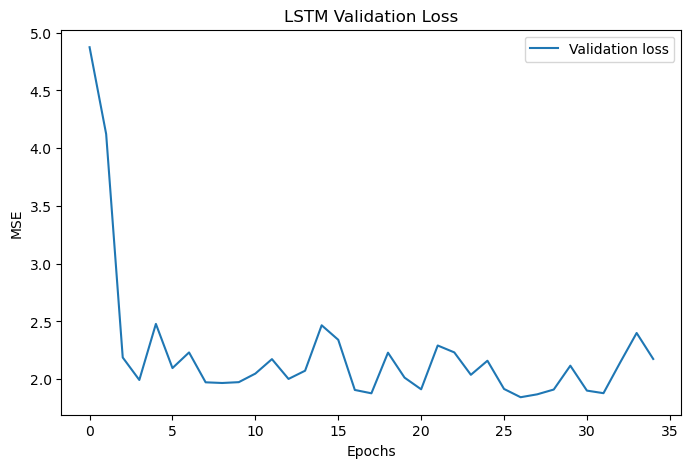

In [84]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(history.history['val_loss'], label='Validation loss')
ax.legend(loc='best')
ax.set_title('LSTM Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

In [83]:
# Compute the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
lstm_train_pred = model1.predict(X_train)
lstm_valid_pred = model1.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_lstm_valid_pred)))

78/78 [==============================] - 2s 21ms/step
Train rmse: 1.3723345870016221
Validation rmse: 1.4362935155940424


In [39]:
# Predict the temperature values for future time points
num_future_points = 365
last_sequence = X_valid_sub[-1]
future_preds = []
for i in range(num_future_points):
    # Make a prediction for the next time point
    next_pred = model_cnn_lstm.predict(last_sequence.reshape(1, subsequences, timesteps, 1))[0, 0]
    future_preds.append(next_pred)
    # Update the last sequence with the new predicted value
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(subsequences, timesteps, 1)

# Plot the actual and predicted temperature values, including the extrapolation
plt.plot(y_valid, color='black', label='actual temperature')
plt.plot(cnn_lstm_valid_pred, color='red', label='predicted temperature')
plt.plot(np.arange(len(cnn_lstm_valid_pred), len(cnn_lstm_valid_pred) + num_future_points),
         future_preds, color='blue', label='extrapolated temperature')
plt.title('CNN-LSTM TEMPERATURE PREDICTION GPS 1')
plt.xlabel('Time(Days)')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.show()


1/1 [==============================] - 0s 44ms/step


ValueError: cannot reshape array of size 16 into shape (2,15,1)